# Parameter estimation using qualitative data

This Notebook eplains the use of qualitative data for parameter estimation, as described in [Schmiester et al. (2020)](https://link.springer.com/article/10.1007/s00285-020-01522-w) and [Schmiester et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.02.06.430039v1.abstract).

## Specification of qualitative data in the PEtab format

The qualitative data can be specified as a non-standard extension to [PEtab](https://journals.plos.org/ploscompbiol/article?rev=2&id=10.1371/journal.pcbi.1008646). Categories can be defined as observable Parameters. Datapoints can be collected into categories by assigning the same `observableParameters` in the measurement file.  pyPESTO recognizes these parameters as optimal scaling categories via the `parameterType`, `parameterGroup` and `parameterCategory` columns in the parameters file. `parameterType=qualitative_scaling` identifies the parameter as an optimal scaling parameter. The `parameterGroup` is an integer, specifying if these parameters are comparable or from different qualitative datasets, where no qualitative relation is known between them (e.g. different observables). `parameterCategory` is also an integer, which defines the category index in ascending order, i.e. `category 1 < category 2 < ...`. Both are indexed starting with 1. An example how this looks like in detail is provided in the `example_qualitative` folder.

## Import model and create pyPESTO objective

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize

import amici
import petab
import numpy as np
from pypesto.hierarchical.optimal_scaling_solver import OptimalScalingInnerSolver
import pypesto.logging
import logging

In [2]:
petab_folder = './example_qualitative/'
yaml_file = 'example_qualitative.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

importer = pypesto.petab.PetabImporter(petab_problem)

model = importer.create_model()

In [3]:
# To enable the optimal scaling approach for qualitative data, set qualitative=True, when creating the objective

objective = importer.create_objective(qualitative=True)
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

## Evaluation of the objective function

After creating the pyPESTO optimal scaling objective function, it can be called with a parameter vector as input. It will output either the objective function value or additionally the gradient, if it is required.

In [4]:
# Evaluation of the objective function without gradients
print(f'Objective function value: {objective(petab_problem.x_nominal_scaled)}')

# The sensi_orders input can be used to specify, that also gradients need to be computed
print(f'Objective function and gradient: {objective(petab_problem.x_nominal_scaled, sensi_orders=(0,1))}')

Objective function value: 0.010643646572165256
Objective function and gradient: (0.010643646546700499, array([ 0.        ,  0.        ,  0.02205115, -0.0266729 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]))


## Run optimization using the optimal scaling approach

We test parameter estimation using the Scipy optimizer Powell (gradient-free) and L-BFGS-B (gradient-based). In this example we use multi-start optimization with 10 starts.

In [5]:
# create a pyPESTO optimizer using the gradient-free Powell algorithm
optimizer_gf = optimize.ScipyOptimizer(method='powell',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})

# create a pyPESTO optimizer using the gradient-based L-BFGS-B algorithm
optimizer_gb = optimize.ScipyOptimizer(method='L-BFGS-B',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})

n_starts = 10

The optimal scaling problem can be solved in different ways, which can be chosen in the pyPESTO problem. The options are:
- method: `standard` / `reduced`
- reparameterized: `True` / `False`
- intervalConstraints: `max` / `max-min`
- minGap: Any float value

It is recommended to use the reduced method with reparameterization and `max` interval constraints as it is the most efficient and robust choice, which we will also use here.

When no options are provided, the default is the reduced and reparameterized formulation with max as interval constraint and `minGap=1e-10`.

### Run optimization with the gradient-free optimizer

In [6]:
# Set the options for solving the optimal scaling problem
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': True,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})
# Run optimization with the gradient-free optimizer
res_gf = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer_gf, engine=engine)

Parameters obtained from history and optimizer do not match: [5.00005182 3.14566114], [4.99999781 3.14603271]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 5
         Function evaluations: 335


Parameters obtained from history and optimizer do not match: [5.00004893 3.145678  ], [4.99999744 3.14605987]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 4
         Function evaluations: 280


Function values from history and optimizer do not match: 0.0005701229465999325, 0.0005735458311820385
Parameters obtained from history and optimizer do not match: [7.05826711 5.19631126], [4.99999588 3.14658678]


Function values from history and optimizer do not match: 0.0005734502742866867, 0.0005735454283402829
Parameters obtained from history and optimizer do not match: [5.01071651 3.15673617], [4.99999842 3.14607726]


Function values from history and optimizer do not match: 0.0005721100685642098, 0.0005768024396834041
Parameters obtained from history and optimizer do not match: [5.49628018 3.61200031], [4.99999817 3.09417051]


Function values from history and optimizer do not match: 0.0005700624461226941, 0.0005735454842456251
Parameters obtained from history and optimizer do not match: [6.74895622 4.8996141 ], [4.99999414 3.14604896]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 6
         Function evaluations: 420


Function values from history and optimizer do not match: 0.0005700517531387574, 0.0005735454504735426
Parameters obtained from history and optimizer do not match: [6.57487115 4.72183443], [4.99999903 3.14612455]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 7
         Function evaluations: 453


Parameters obtained from history and optimizer do not match: [5.00004954 3.14558369], [4.99999373 3.1460074 ]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 4
         Function evaluations: 335


Parameters obtained from history and optimizer do not match: [5.00004705 3.14566581], [4.9999937  3.14603507]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 5
         Function evaluations: 338


Function values from history and optimizer do not match: 0.0005735055013969665, 0.0005772033035415648
Parameters obtained from history and optimizer do not match: [5.43252657 3.53472179], [4.99999873 3.09101057]


### Run optimization with the gradient-based optimizer

In [7]:
res_gb = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer_gb, engine=engine)

### Compare results

Gradient-based optimization leads to improved computation times

In [9]:
time_gf = res_gf.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-free optimizer: {np.mean(time_gf)}")

time_gb = res_gb.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-based optimizer: {np.mean(time_gb)}")


Mean computation time for gradient-free optimizer: 8.280100584030151
Mean computation time for gradient-based optimizer: 3.698576045036316


Both optimizers yield the same final objective function values

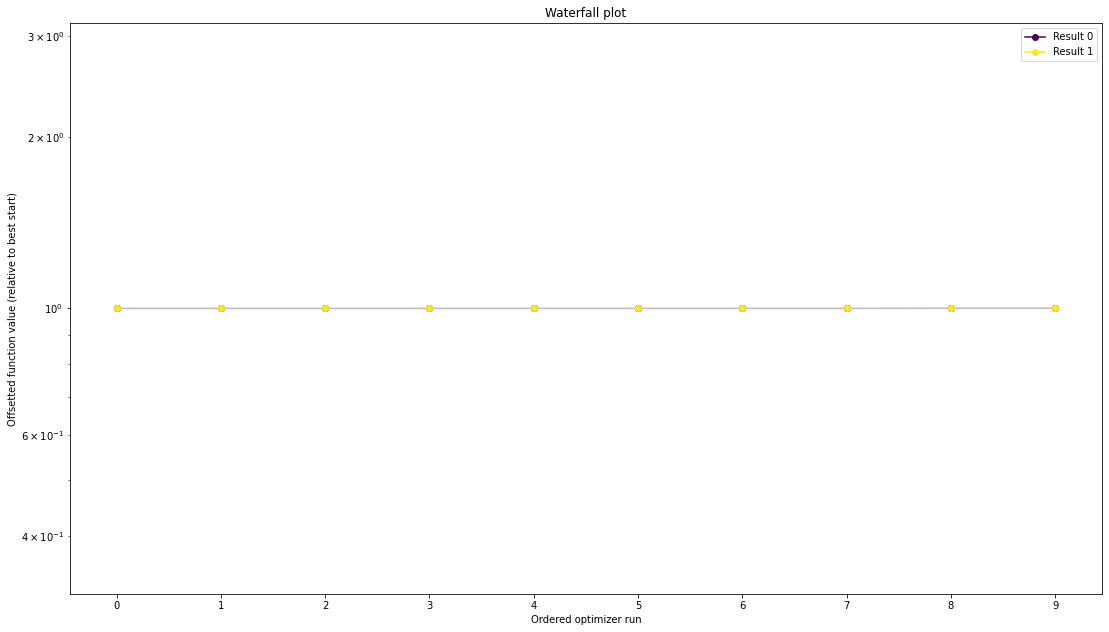

In [10]:
from pypesto.visualize import waterfall

waterfall([res_gf, res_gb])